In [1]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import TargetEncoder

# import xgboost as xgb
import lightgbm as lgb

from optuna.integration import LightGBMPruningCallback #XGBoostPruningCallback, CatBoostPruningCallback
import optuna

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
model_str = "lgb_"
study_name = 'minus_bin_'

# feature_list = ['weight_capacity_te', 'brand', 'material', 'size', 'compartments', 'style', 'color', 'laptop_compartment', 'is_waterproof']
TE_features = [
    'weight_capacity', 'compartments',  'brand', 'color',
    'laptop_compartment', 'is_waterproof', 'size', 'material', 
]
TE_new_cols = [col + "_te" for col in TE_features]
features = TE_features + TE_new_cols
features = [col for col in features if col not in [
    'laptop_compartment', 'is_waterproof', 
    'size', 'style', 'wc_decimal_count', # New this test
]]


In [20]:
features

['weight_capacity',
 'compartments',
 'brand',
 'color',
 'material',
 'weight_capacity_te',
 'compartments_te',
 'brand_te',
 'color_te',
 'laptop_compartment_te',
 'is_waterproof_te',
 'size_te',
 'material_te']

In [18]:
categorical_cols = [
    'compartments', 'wc_decimal_count',
    'brand', 'color', 'laptop_compartment', 
    'is_waterproof', 'size', 'material', 'style']
train_df[categorical_cols] = train_df[categorical_cols].astype('category')


In [19]:
kf = KFold(n_splits=10, shuffle=True, random_state=40)
data_splits = []

for train_index, val_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    te = TargetEncoder(target_type="continuous", smooth=20)
    # train_fold["weight_capacity_te"] = te.fit_transform(train_fold[["weight_capacity"]], train_fold[target])
    # val_fold["weight_capacity_te"] = te.transform(val_fold[["weight_capacity"]])
    train_fold[TE_new_cols] = (
        te.fit_transform(train_fold[TE_features], train_fold[target])
    )
    val_fold[TE_new_cols] = (
        te.transform(val_fold[TE_features])
    )
    data_splits.append((train_fold, val_fold))

In [21]:
train_fold[features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3594887 entries, 0 to 3994317
Data columns (total 13 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   weight_capacity        float64 
 1   compartments           category
 2   brand                  category
 3   color                  category
 4   material               category
 5   weight_capacity_te     float64 
 6   compartments_te        float64 
 7   brand_te               float64 
 8   color_te               float64 
 9   laptop_compartment_te  float64 
 10  is_waterproof_te       float64 
 11  size_te                float64 
 12  material_te            float64 
dtypes: category(4), float64(9)
memory usage: 288.0 MB


In [22]:
%%time

from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        'random_state': 42,
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 5, 1000), # the {n}th accuracy on the validation set does not improve, stop training
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True,

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 100),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        # 'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),

        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 2, 10000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 1000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 1000, 20000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        # subsample is ignored when bagging_fraction is set
        # 'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }

    rmse_list = []
    for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

        train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
        valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
      
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train_0', 'valid_0'],
            callbacks=[
                # LightGBMPruningCallback(trial, "l1", valid_name="valid_0"),
                LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
                lgb.log_evaluation(-1)                   # Suppress training logs
            ]
        )
        y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(valid_fold[target], y_pred)
        # rmse = mean_absolute_error(valid_fold[target], y_pred)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=model_str + study_name + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=1000)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params["force_row_wise"] = True

[I 2025-02-19 07:55:35,650] A new study created in RDB with name: lgb_minus_bin_2025-02-19_07-55


[I 2025-02-19 08:05:39,182] Trial 0 finished with value: 38.66905596377945 and parameters: {'early_stopping_rounds': 708, 'cat_l2': 64.84696554402605, 'feature_fraction': 0.8078972070898134, 'learning_rate': 0.22983699179467348, 'max_bin': 207, 'max_depth': 922, 'min_samples_leaf': 42, 'n_estimators': 14727, 'num_leaves': 255, 'lambda_l1': 0.0025965807508630755, 'lambda_l2': 5.554940121319678e-06}. Best is trial 0 with value: 38.66905596377945.
[I 2025-02-19 08:13:27,307] Trial 1 finished with value: 38.66681718235135 and parameters: {'early_stopping_rounds': 797, 'cat_l2': 1.7526805034261888, 'feature_fraction': 0.8272602907753319, 'learning_rate': 0.4411943329684009, 'max_bin': 3286, 'max_depth': 644, 'min_samples_leaf': 30, 'n_estimators': 11961, 'num_leaves': 116, 'lambda_l1': 2.3382652478907525e-08, 'lambda_l2': 0.17532341561823792}. Best is trial 1 with value: 38.66681718235135.
[I 2025-02-19 11:50:51,691] Trial 2 finished with value: 38.65617606556428 and parameters: {'early_sto


Number of finished trials: 1000
Best trial: 4
Best value (RMSE): 38.655625200050665
Best hyperparameters: {'early_stopping_rounds': 655, 'cat_l2': 60.84125326753434, 'feature_fraction': 0.7721488102742591, 'learning_rate': 0.01178957655269001, 'max_bin': 2913, 'max_depth': 85, 'min_samples_leaf': 24, 'n_estimators': 15009, 'num_leaves': 60, 'lambda_l1': 0.13153160123626256, 'lambda_l2': 1.0751120194332953e-08}
CPU times: user 1d 1h 29min 27s, sys: 5h 14min 2s, total: 1d 6h 43min 29s
Wall time: 12h 5min 1s


In [ ]:
Best value (RMSE): 38.65543923885193
Best hyperparameters: {'early_stopping_rounds': 390, 'bagging_fraction': 0.9954892076290114, 'bagging_freq': 3, 'cat_l2': 19.943225836972967, 'extra_trees': False, 'feature_fraction': 0.9583014726425529, 'learning_rate': 0.21124741547142464, 'max_bin': 7566, 'max_depth': 648, 'min_samples_leaf': 14, 'n_estimators': 1570, 'num_leaves': 68, 'lambda_l1': 7.772617123196223e-06, 'lambda_l2': 0.0006810978623249646}
CPU times: user 1d 11h 24min 23s, sys: 4h 5s, total: 1d 15h 24min 29s
Wall time: 11h 20min

In [8]:
best_params

{'early_stopping_rounds': 685,
 'cat_l2': 32.66453196073856,
 'extra_trees': False,
 'feature_fraction': 0.47288340354846004,
 'learning_rate': 0.10908881768801715,
 'max_bin': 8467,
 'max_depth': 237,
 'min_samples_leaf': 98,
 'n_estimators': 7470,
 'num_leaves': 101,
 'lambda_l1': 0.0010914923491720555,
 'lambda_l2': 9.21980448087608e-06,
 'random_state': 42,
 'verbose': 0,
 'metric': 'rmse',
 'force_row_wise': True}

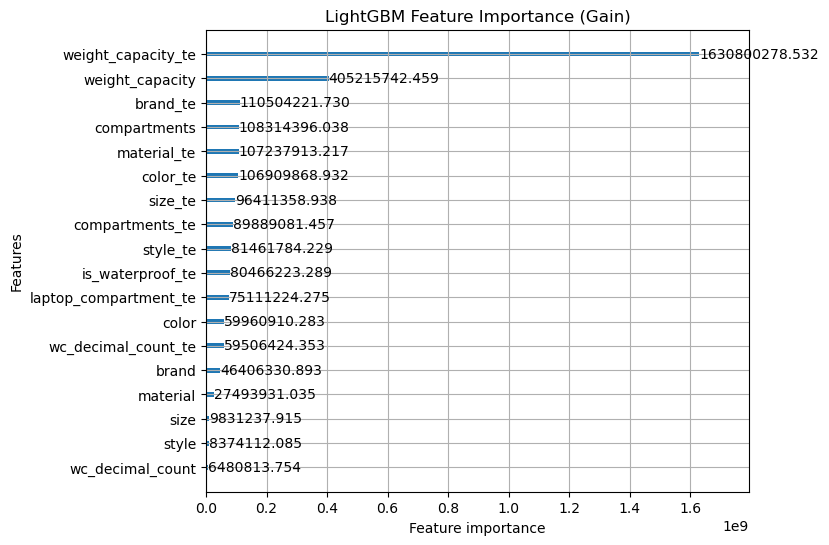

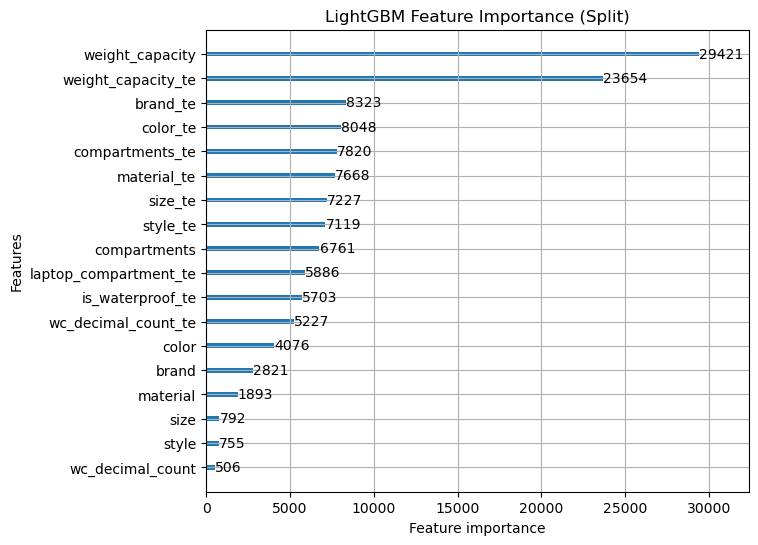

In [16]:
for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    break

model = lgb.train(params=best_params, train_set=train_data, valid_sets=[train_data, valid_data],
)

lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()